<h1>MBA Latency Charts IPv4 </h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>

<h7>3/21/22</h7>

In [2]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [48]:
%%toggle_code
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline




print('Executed')

<h4> BigQuery SQL Queries for Latency

In [4]:
peakHourLatencySQL = """
SELECT mt.ISP as isp, mt.Technology as tech, 
    avg(rtt_avg/1000) as avgRTT, 
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(50)] as medianRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(80)] as slowestTwentyPctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(95)] as slowest5PctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(5)] as fastest5PctRTT,
    COUNT(DISTINCT lat.unit_id) as totalBoxes
FROM `broadband-data.mba_data.curr_udplatency` as lat
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON lat.unit_id=mt.Unit_ID 
WHERE (EXTRACT(HOUR FROM lat.dtime) >= 19) AND (EXTRACT(HOUR FROM lat.dtime) <=23) 
GROUP BY mt.ISP, mt.Technology
HAVING COUNT(DISTINCT lat.unit_id) > 10
ORDER BY mt.Technology
"""


fullDayLatencySQL = """
SELECT mt.ISP as isp, mt.Technology as tech, 
    avg(rtt_avg/1000) as avgRTT, 
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(50)] as medianRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(80)] as slowestTwentyPctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(95)] as slowest5PctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(5)] as fastest5PctRTT,
    COUNT(DISTINCT lat.unit_id) as totalBoxes
FROM `broadband-data.mba_data.curr_udplatency` as lat
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON lat.unit_id=mt.Unit_ID 
GROUP BY mt.ISP, mt.Technology
HAVING COUNT(DISTINCT lat.unit_id) > 10
ORDER BY mt.Technology
"""

# creating dataframes

peakHourLatency = client.query(peakHourLatencySQL).to_dataframe()
fullDayLatency = client.query(fullDayLatencySQL).to_dataframe()
print("Executed")

Executed


<h3> Latency Charts by ISP and Technology

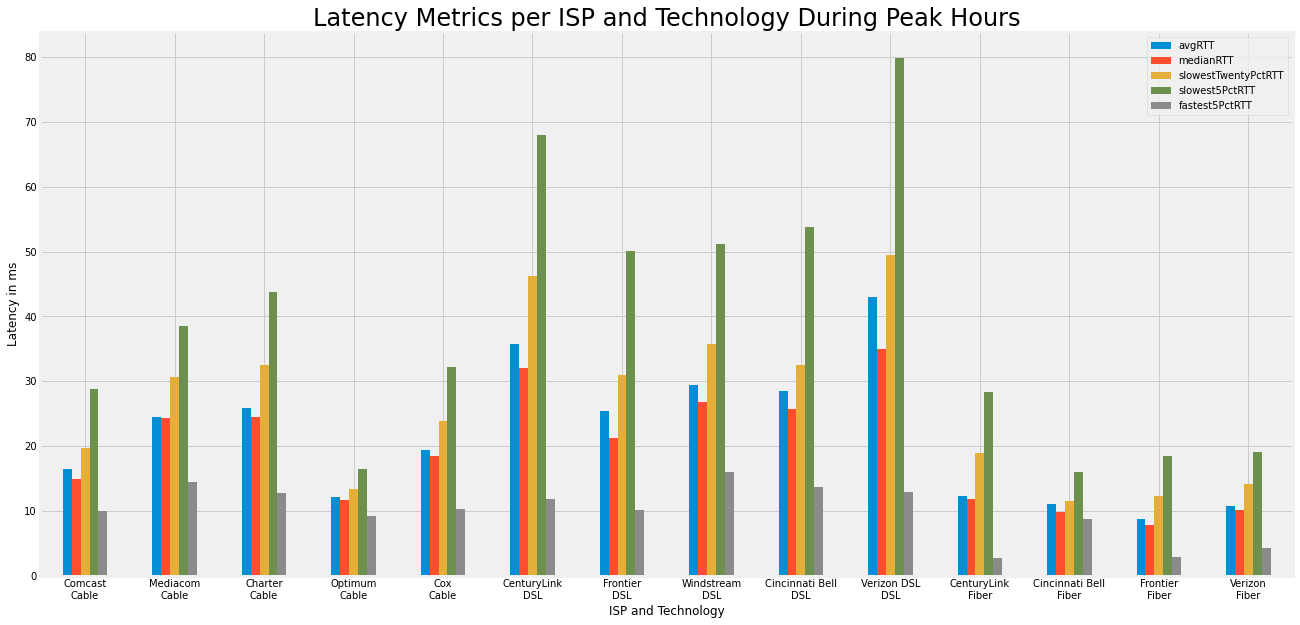

In [26]:
chartData = peakHourLatency
ispTech =  list(chartData['isp'] +"\n"+ chartData['tech'])
chartData['ispTech'] = ispTech




ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowestTwentyPctRTT','slowest5PctRTT', 'fastest5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


# plt.yticks(np.arange(0, 150, 10))
# plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('ISP and Technology')
ax.set_ylabel('Latency in ms')
ax.set_title('Latency Metrics per ISP and Technology During Peak Hours', fontsize=24)


plt.show()

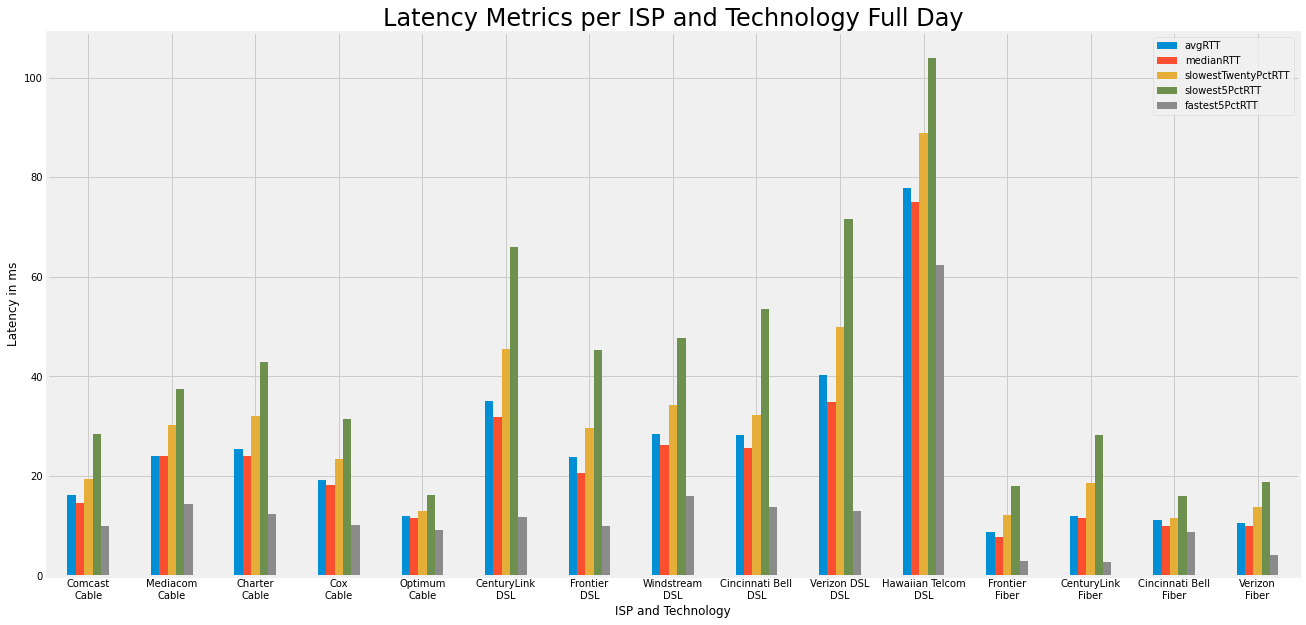

In [27]:
chartData = fullDayLatency
ispTech =  list(chartData['isp'] +"\n"+ chartData['tech'])
chartData['ispTech'] = ispTech




ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowestTwentyPctRTT','slowest5PctRTT', 'fastest5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


ax.set_xlabel('ISP and Technology')
ax.set_ylabel('Latency in ms')
ax.set_title('Latency Metrics per ISP and Technology Full Day', fontsize=24)


plt.show()

<hr>

<h4> BigQuery SQL Queries for Latency by tier

In [9]:
peakHourTierLatencySQL = """
SELECT mt.ISP as isp, mt.Technology as tech, mt.Download as downloadTier,
    avg(rtt_avg/1000) as avgRTT, 
    min(rtt_avg/1000) as minAvg,
    avg(rtt_min/1000) as min,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(50)] as medianRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(80)] as slowestTwentyPctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(95)] as slowest5PctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(5)] as fastest5PctRTT,
    COUNT(DISTINCT lat.unit_id) as totalBoxes
FROM `broadband-data.mba_data.curr_udplatency` as lat
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON lat.unit_id=mt.Unit_ID 
WHERE (EXTRACT(HOUR FROM lat.dtime) >= 19) AND (EXTRACT(HOUR FROM lat.dtime) <=23) 
GROUP BY mt.ISP, mt.Technology, mt.Download
HAVING COUNT(DISTINCT lat.unit_id) > 10
ORDER BY mt.Download, mt.Technology
"""

fullDayTierLatencySQL = """
SELECT mt.ISP as isp, mt.Technology as tech, mt.Download as downloadTier,
    avg(rtt_avg/1000) as avgRTT, 
    min(rtt_avg/1000) as minAvg,
    avg(rtt_min/1000) as min,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(50)] as medianRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(80)] as slowestTwentyPctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(95)] as slowest5PctRTT,
    APPROX_QUANTILES(lat.rtt_avg/1000, 100)[OFFSET(5)] as fastest5PctRTT,
    COUNT(DISTINCT lat.unit_id) as totalBoxes
FROM `broadband-data.mba_data.curr_udplatency` as lat
INNER JOIN `broadband-data.mba_data.unit-profile-sept2020` as mt ON lat.unit_id=mt.Unit_ID 
GROUP BY mt.ISP, mt.Technology, mt.Download
HAVING COUNT(DISTINCT lat.unit_id) > 10
ORDER BY mt.Download, mt.Technology
"""

peakHourTierLatency = client.query(peakHourTierLatencySQL).to_dataframe()
fullDayTierLatency = client.query(fullDayTierLatencySQL).to_dataframe()
print("Executed")


Executed


<h4> Python functions for normalzing dataframes to tiers

In [33]:
def dfNormalizer(df):
    
    ispTech =  df['downloadTier'].astype(str) +"\n"+ df['isp'] +"\n"+ df['tech']      
    tier = df['downloadTier']
    isp = df['isp']
    tech = df['tech']
    avgRTT = df['avgRTT']
    medianRTT = df['medianRTT']
    slowTwentyPctRTT = df['slowestTwentyPctRTT']
    slowFivePctRTT = df['slowest5PctRTT']
    fast5PctRTT = df['fastest5PctRTT']

    
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avgRTT=avgRTT, 
                               medianRTT=medianRTT, slowTwentyPctRTT=slowTwentyPctRTT,
                               slowFivePctRTT=slowFivePctRTT, fast5PctRTT=fast5PctRTT))
    return result



In [36]:
# DSL ISPs: Windstream + Centurylink
# Cable ISPs: Comcast, Optimum, Mediacom
# Fiber ISPs: Frontier, Verizon 

# Normalized Dataframes:
peakLatencyChart = dfNormalizer(peakHourTierLatency)
fullDayLatencyChart = dfNormalizer(fullDayTierLatency)


# Peak latency DSL 
peakLatencyDSL = peakLatencyChart.where(peakLatencyChart.tech == "DSL").dropna()
peakLatencyDSL = peakLatencyDSL[(peakLatencyDSL['isp'] == "Windstream") |(peakLatencyDSL['isp'] == "CenturyLink")]

# Peak Latency Cable
peakLatencyCable = peakLatencyChart.where(peakLatencyChart.tech == "Cable").dropna()
peakLatencyCable = peakLatencyCable[(peakLatencyCable['isp'] =='Comcast') | (peakLatencyCable['isp'] =='Optimum') | 
                        (peakLatencyCable['isp'] =='Mediacom')]
# Peak Latency Fiber
peakLatencyFiber = peakLatencyChart.where(peakLatencyChart.tech == "Fiber").dropna()
peakLatencyFiber = peakLatencyFiber[(peakLatencyFiber['isp'] =='Frontier') | (peakLatencyFiber['isp'] =='Verizon')]


# Full-day Latency DSL
fullDayLatencyDSL = fullDayLatencyChart.where(fullDayLatencyChart.tech == "DSL").dropna()
fullDayLatencyDSL = fullDayLatencyDSL[(fullDayLatencyDSL['isp'] == "Windstream") |(fullDayLatencyDSL['isp'] == "CenturyLink")]


# Full-day Latency Cable
fullDayLatencyCable = fullDayLatencyChart.where(fullDayLatencyChart.tech == "Cable").dropna()
fullDayLatencyCable = fullDayLatencyCable[(fullDayLatencyCable['isp'] =='Comcast') | (fullDayLatencyCable['isp'] =='Optimum') | 
                        (fullDayLatencyCable['isp'] =='Mediacom')]

# Full-day Latency Fiber
fullDayLatencyFiber = fullDayLatencyChart.where(fullDayLatencyChart.tech == "Fiber").dropna()
fullDayLatencyFiber = fullDayLatencyFiber[(fullDayLatencyFiber['isp'] =='Frontier') | (fullDayLatencyFiber['isp'] =='Verizon')]





<h3> Latency Charts by ISP, Technology, and Download Tier

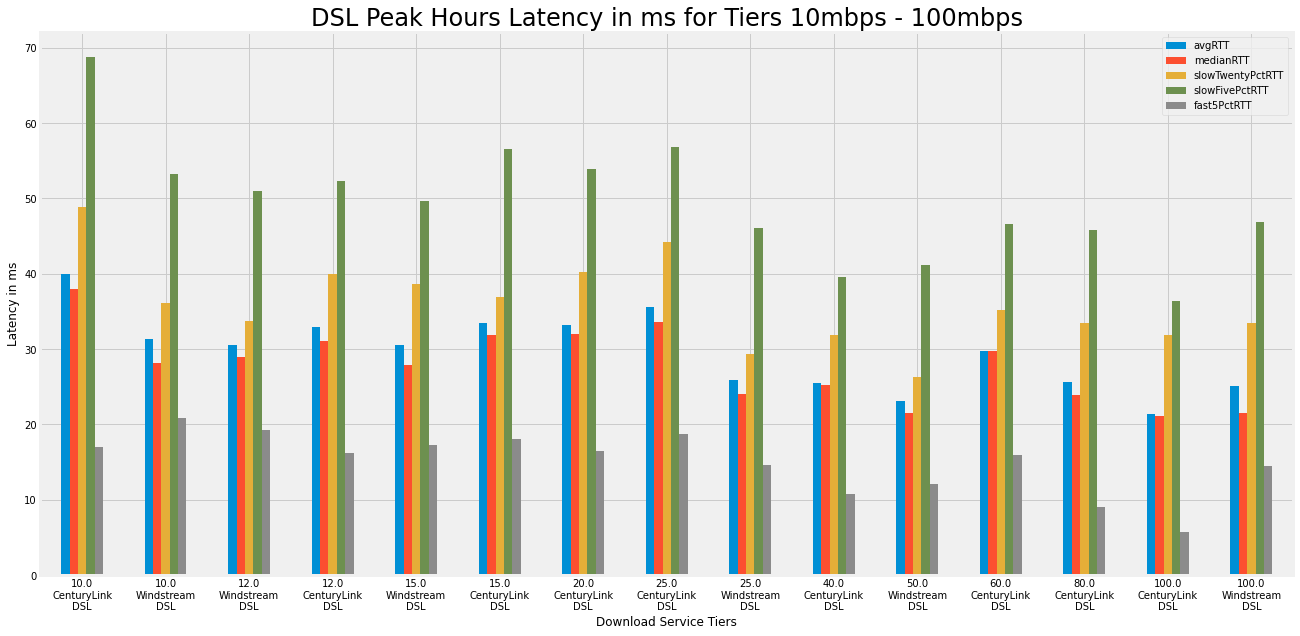

In [47]:
chartData = peakLatencyDSL
chartData = chartData[chartData.tier >= 10]


ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowTwentyPctRTT', 'slowFivePctRTT', 'fast5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Latency in ms')
ax.set_title('DSL Peak Hours Latency in ms for Tiers 10mbps - 100mbps', fontsize=24)


plt.show()

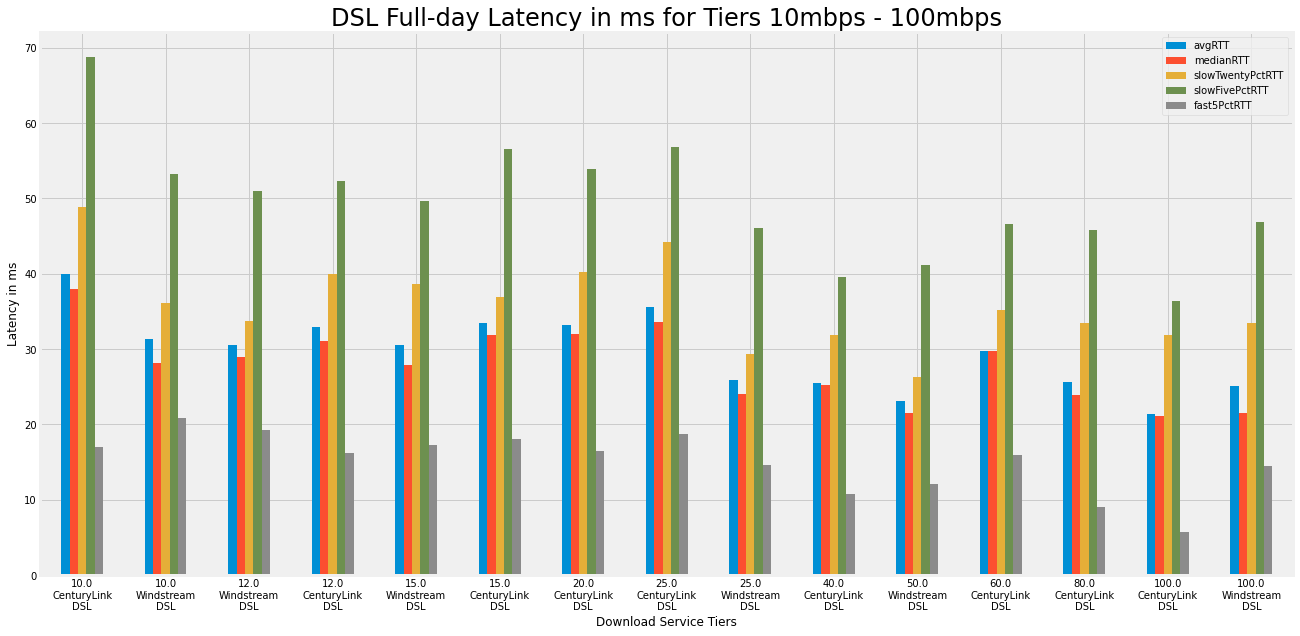

In [40]:
chartData = peakLatencyDSL
chartData = chartData[chartData.tier >= 10]


ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowTwentyPctRTT', 'slowFivePctRTT', 'fast5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Latency in ms')
ax.set_title('DSL Full-day Latency in ms for Tiers 10mbps - 100mbps', fontsize=24)


plt.show()

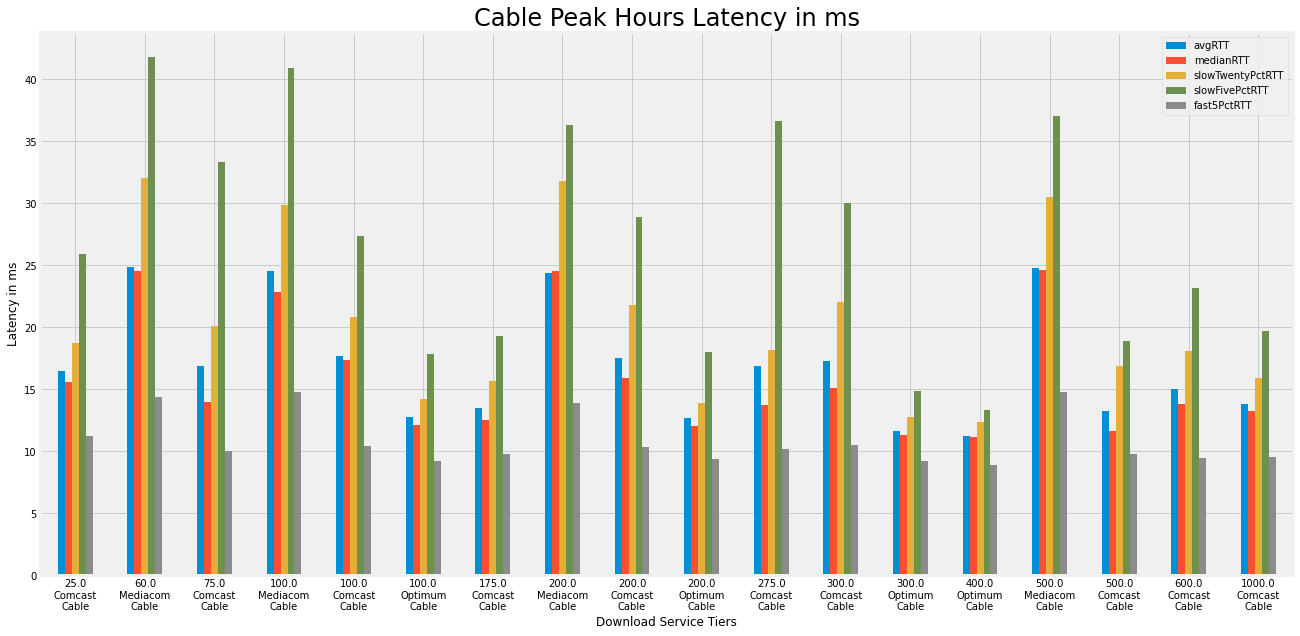

In [42]:
chartData = peakLatencyCable

ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowTwentyPctRTT', 'slowFivePctRTT', 'fast5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Latency in ms')
ax.set_title('Cable Peak Hours Latency in ms', fontsize=24)


plt.show()

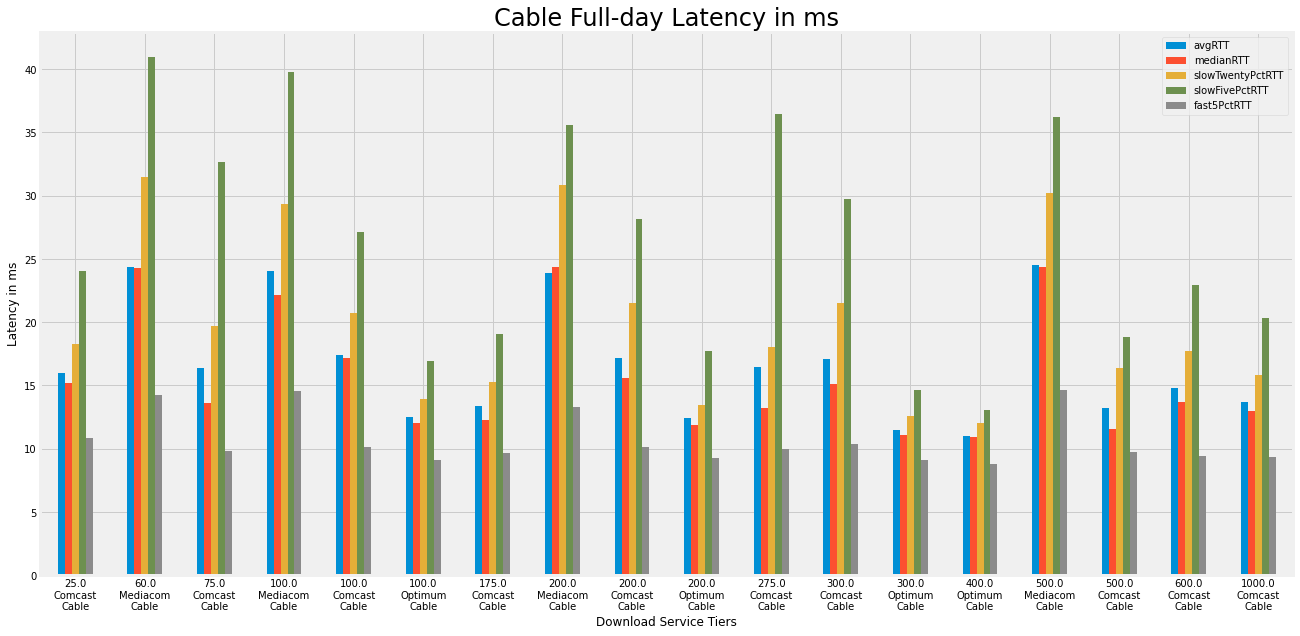

In [43]:
chartData = fullDayLatencyCable





ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowTwentyPctRTT', 'slowFivePctRTT', 'fast5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


# plt.yticks(np.arange(0, 140, 10))
# plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Latency in ms')
ax.set_title('Cable Full-day Latency in ms', fontsize=24)


plt.show()

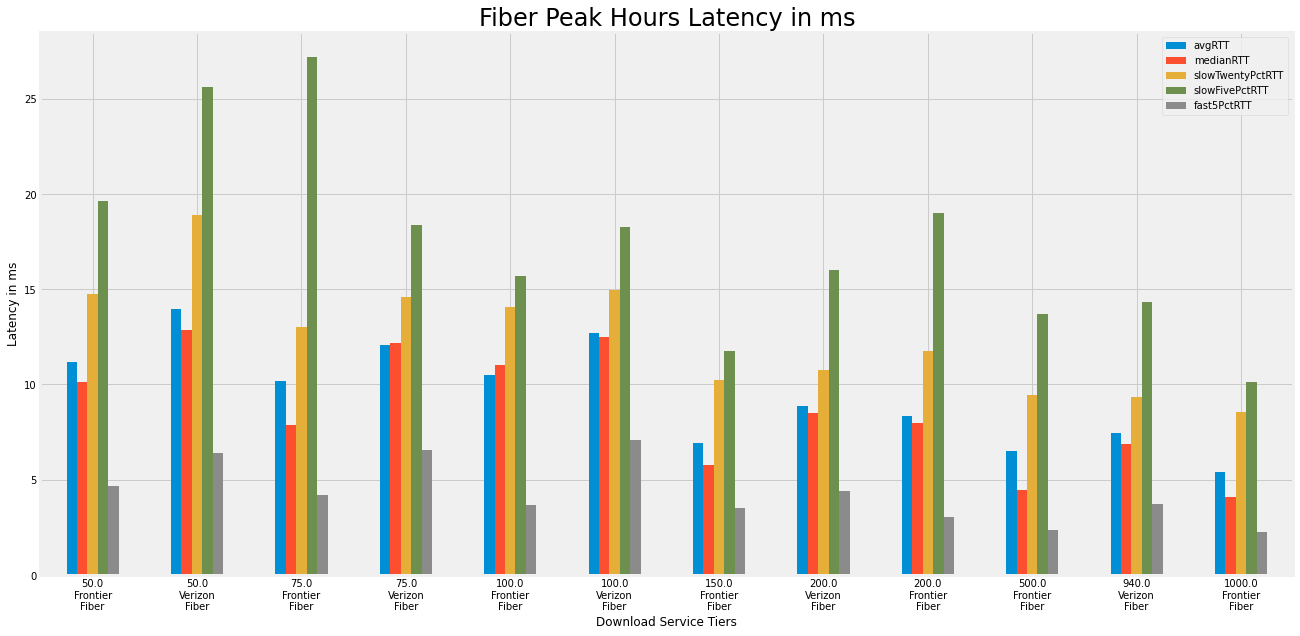

In [44]:
chartData = peakLatencyFiber



ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowTwentyPctRTT', 'slowFivePctRTT', 'fast5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


# plt.yticks(np.arange(0, 140, 10))
# plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Latency in ms')
ax.set_title('Fiber Peak Hours Latency in ms', fontsize=24)


plt.show()

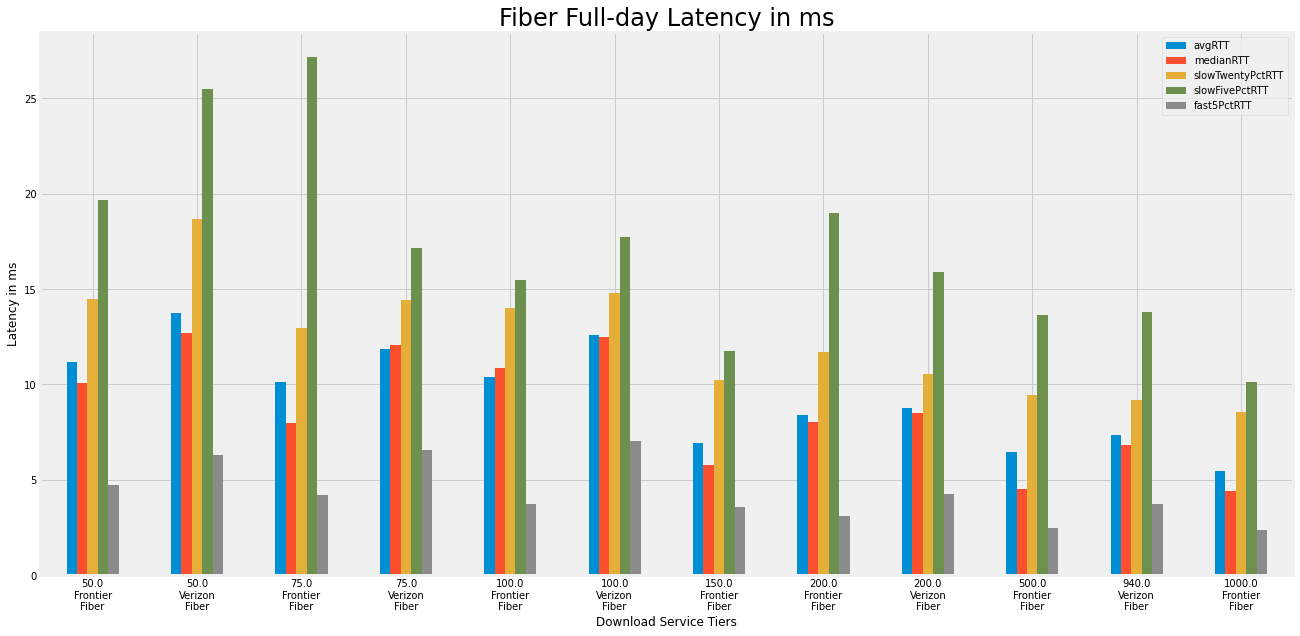

In [46]:
chartData = fullDayLatencyFiber



ax = chartData.plot(x = "ispTech", y = ['avgRTT', 'medianRTT', 'slowTwentyPctRTT', 'slowFivePctRTT', 'fast5PctRTT'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Latency in ms')
ax.set_title('Fiber Full-day Latency in ms', fontsize=24)


plt.show()